# 1. Install and Import Dependencies

In [100]:
import warnings
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import json
from prophet.serialize import model_to_json, model_from_json
import itertools
import anvil.server
import os

warnings.simplefilter("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# 2. Load and Filter Data

In [10]:
df = pd.read_csv("dataset.csv")
df = df[(df["Product"] == "TESLA_MODEL_X") & (df["Store"] == "LOS_ANGELES")]

In [11]:
df

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531000
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000000
...,...,...,...,...
1075,20201212,LOS_ANGELES,TESLA_MODEL_X,3167.594500
1076,20201213,LOS_ANGELES,TESLA_MODEL_X,3167.594500
1077,20201214,LOS_ANGELES,TESLA_MODEL_X,3383.354511
1078,20201215,LOS_ANGELES,TESLA_MODEL_X,2714.591329


In [8]:
df.Store.unique()

array(['LOS_ANGELES', 'SAN_FRANCISCO'], dtype=object)

In [9]:
df.Product.unique()

array(['TESLA_MODEL_X', 'TESLA_MODEL_S'], dtype=object)

# 3. Preprocess and Create Partitions

## Create Dates

In [18]:
df.head()

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000


In [20]:
df["ds"] = pd.to_datetime(df["Date"], format="%Y%m%d")

In [22]:
df["day"] = df["ds"].dt.day
df["month"] = df["ds"].dt.month
df["year"] = df["ds"].dt.year

In [23]:
df

,Date,Store,Product,Value,ds,day,month,year
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000000,2018-01-01,1,1,2018
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531000,2018-01-02,2,1,2018
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000000,2018-01-03,3,1,2018
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000000,2018-01-04,4,1,2018
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000000,2018-01-05,5,1,2018
...,...,...,...,...,...,...,...,...
1075,20201212,LOS_ANGELES,TESLA_MODEL_X,3167.594500,2020-12-12,12,12,2020
1076,20201213,LOS_ANGELES,TESLA_MODEL_X,3167.594500,2020-12-13,13,12,2020
1077,20201214,LOS_ANGELES,TESLA_MODEL_X,3383.354511,2020-12-14,14,12,2020
1078,20201215,LOS_ANGELES,TESLA_MODEL_X,2714.591329,2020-12-15,15,12,2020


In [25]:
df = df.drop(["Date", "Store", "Product", "day", "month", "year"], axis=1)

In [27]:
df.columns = ["y", "ds"]

In [28]:
df

,y,ds
0,2926.000000,2018-01-01
1,2687.531000,2018-01-02
2,2793.000000,2018-01-03
3,2394.000000,2018-01-04
4,2660.000000,2018-01-05
...,...,...
1075,3167.594500,2020-12-12
1076,3167.594500,2020-12-13
1077,3383.354511,2020-12-14
1078,2714.591329,2020-12-15


## Visualise the Data to Determine Appropriate Partitions

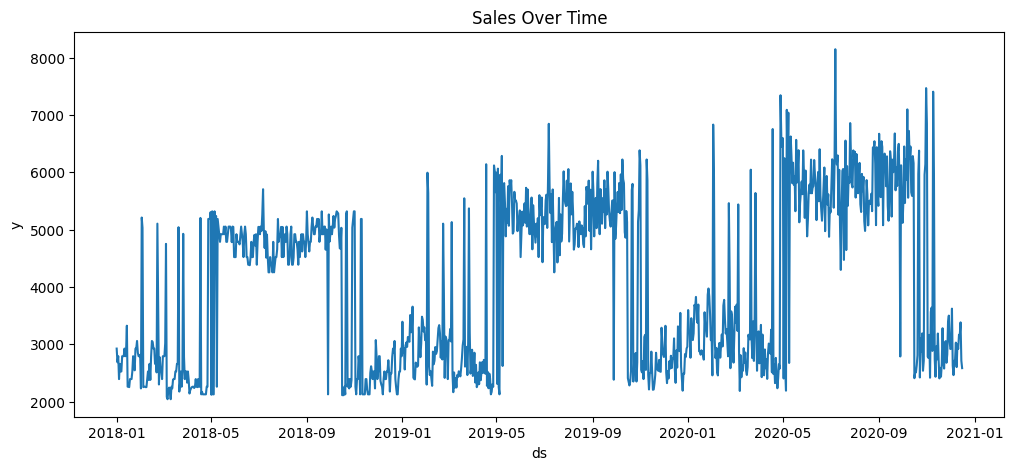

In [32]:
plt.figure(figsize=(12, 5))
sns.lineplot(x="ds", y="y", data=df).set_title("Sales Over Time")
plt.show()

## Create Train and Test Splits

In [33]:
df["ds"].min()

Timestamp('2018-01-01 00:00:00')

In [34]:
df["ds"].max()

Timestamp('2020-12-16 00:00:00')

In [35]:
train = df[df["ds"] < "2020-06-30 00:00:00"]
test = df[df["ds"] >= "2020-06-30 00:00:00"]

In [37]:
train.shape

(910, 2)

# 4. Train Model

In [39]:
m = Prophet() #interval_width = .99 as argument to set up if needed
model = m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/hnh_qpdm.json
DEBUG:cmdstanpy:input tempfile: /var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/3pmbd64m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/valentinmonney/Desktop/Full Stack Machine Learning/fullstack/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27537', 'data', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/hnh_qpdm.json', 'init=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/3pmbd64m.json', 'output', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/prophet_model2joqw_sp/prophet_model-20231215133256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:

# 5. Evaluate Model

## Make Predictions on Test Set

In [43]:
yhat = m.predict(test[["ds"]])

In [44]:
yhat

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-30,4355.763932,4497.917723,6509.773636,4355.763932,4355.763932,1113.302299,1113.302299,1113.302299,-7.935386,-7.935386,-7.935386,1121.237685,1121.237685,1121.237685,0.0,0.0,0.0,5469.066231
1,2020-07-01,4356.709089,4440.164826,6514.498462,4356.709089,4356.709089,1099.106958,1099.106958,1099.106958,-13.477032,-13.477032,-13.477032,1112.583990,1112.583990,1112.583990,0.0,0.0,0.0,5455.816047
2,2020-07-02,4357.654245,4482.443273,6430.161402,4357.654245,4357.654245,1121.361288,1121.361288,1121.361288,15.737098,15.737098,15.737098,1105.624189,1105.624189,1105.624189,0.0,0.0,0.0,5479.015533
3,2020-07-03,4358.599402,4370.883759,6502.787676,4358.599402,4358.599402,1061.175325,1061.175325,1061.175325,-39.351738,-39.351738,-39.351738,1100.527063,1100.527063,1100.527063,0.0,0.0,0.0,5419.774728
4,2020-07-04,4359.544559,4449.964197,6454.993913,4359.544559,4359.544559,1071.483915,1071.483915,1071.483915,-25.910997,-25.910997,-25.910997,1097.394912,1097.394912,1097.394912,0.0,0.0,0.0,5431.028474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2020-12-12,4511.714798,2156.794728,4093.544817,4511.705980,4511.723475,-1386.362186,-1386.362186,-1386.362186,-25.910997,-25.910997,-25.910997,-1360.451189,-1360.451189,-1360.451189,0.0,0.0,0.0,3125.352612
166,2020-12-13,4512.659955,2180.220739,4183.679928,4512.651041,4512.668718,-1296.772885,-1296.772885,-1296.772885,47.692880,47.692880,47.692880,-1344.465765,-1344.465765,-1344.465765,0.0,0.0,0.0,3215.887070
167,2020-12-14,4513.605111,2169.491121,4259.168885,4513.596108,4513.613959,-1306.033827,-1306.033827,-1306.033827,23.245174,23.245174,23.245174,-1329.279001,-1329.279001,-1329.279001,0.0,0.0,0.0,3207.571284
168,2020-12-15,4514.550268,2167.268782,4242.190424,4514.541194,4514.559200,-1322.927014,-1322.927014,-1322.927014,-7.935386,-7.935386,-7.935386,-1314.991628,-1314.991628,-1314.991628,0.0,0.0,0.0,3191.623254


In [45]:
mean_absolute_error(test[["y"]], yhat[["yhat"]])

702.3627050102057

## Make New Predictions

In [57]:
future = m.make_future_dataframe(periods=365, freq="D")
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1270,2021-06-25,4696.020367,4820.949016,6788.262214,4695.994114,4696.048305,1144.002557,1144.002557,1144.002557,-39.351738,-39.351738,-39.351738,1183.354295,1183.354295,1183.354295,0.0,0.0,0.0,5840.022924
1271,2021-06-26,4696.965523,4870.656457,6868.501490,4696.939128,4696.993587,1144.726407,1144.726407,1144.726407,-25.910997,-25.910997,-25.910997,1170.637404,1170.637404,1170.637404,0.0,0.0,0.0,5841.691931
1272,2021-06-27,4697.910680,4875.489966,6879.956385,4697.884142,4697.938868,1205.625307,1205.625307,1205.625307,47.692880,47.692880,47.692880,1157.932427,1157.932427,1157.932427,0.0,0.0,0.0,5903.535987
1273,2021-06-28,4698.855837,4903.950572,6919.219365,4698.829156,4698.884149,1168.869694,1168.869694,1168.869694,23.245174,23.245174,23.245174,1145.624520,1145.624520,1145.624520,0.0,0.0,0.0,5867.725531
1274,2021-06-29,4699.800994,4797.374558,6825.427380,4699.774170,4699.829430,1126.145896,1126.145896,1126.145896,-7.935386,-7.935386,-7.935386,1134.081282,1134.081282,1134.081282,0.0,0.0,0.0,5825.946890


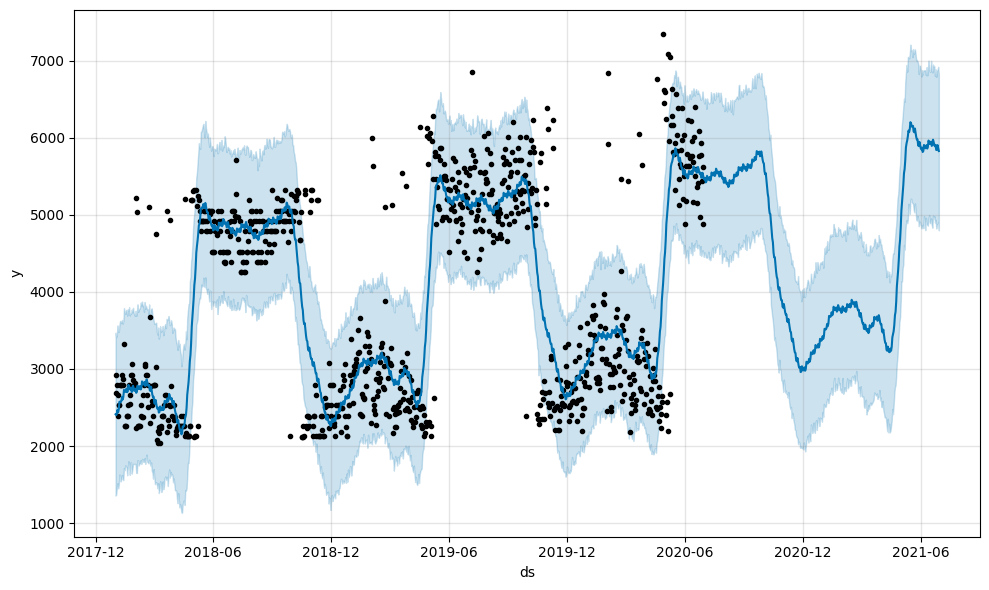

In [58]:
plot1 = m.plot(forecast)

In [52]:
forecast[["ds", "yhat", "yhat_upper", "yhat_lower"]].tail()

,ds,yhat,yhat_upper,yhat_lower
1405,2021-11-07,4033.243351,5076.807480,3011.211930
1406,2021-11-08,3978.077904,4888.315447,2973.962764
1407,2021-11-09,3914.523609,4964.933626,2918.626231
1408,2021-11-10,3874.954608,4951.054746,2875.475113
1409,2021-11-11,3868.575831,4892.589824,2863.486701


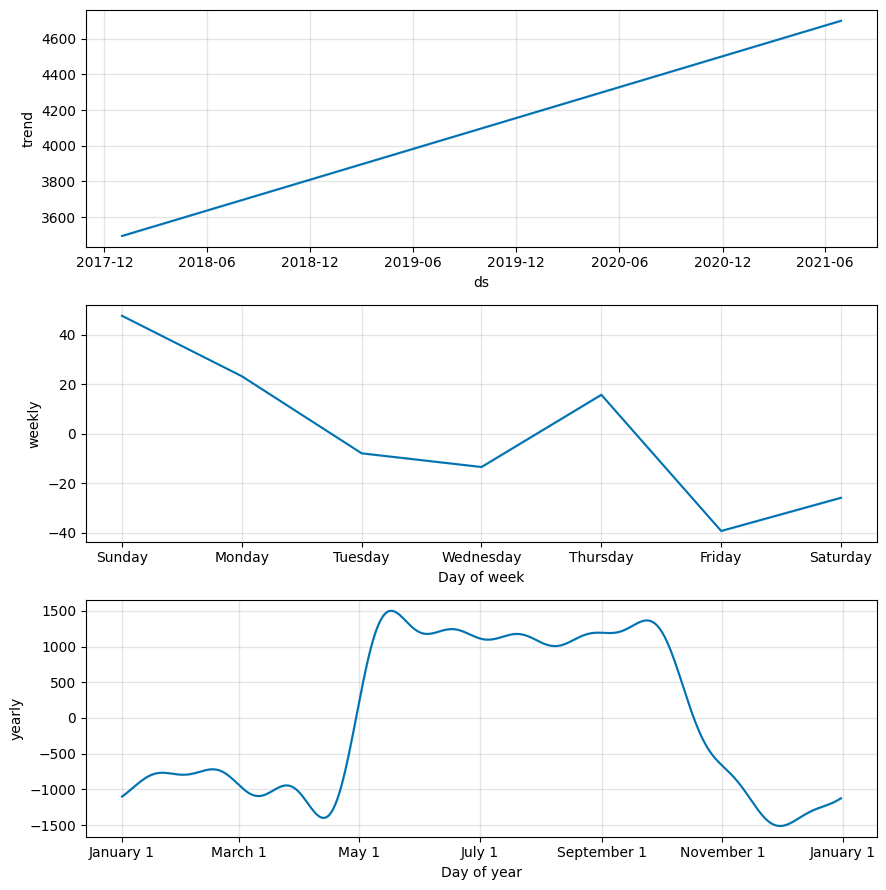

In [59]:
plot2 = m.plot_components(forecast)

# 6. Save Model

In [61]:
with open("serialized_model.json", "w") as fout:
    json.dump(model_to_json(m), fout)

In [62]:
with open("serialized_model.json", "r") as fin:
    m = model_from_json(json.load(fin))

In [63]:
future = m.make_future_dataframe(periods=100, freq="D")
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1005,2020-10-03,4445.553824,4500.356986,6484.829882,4445.550194,4445.557406,1079.450553,1079.450553,1079.450553,-25.910997,-25.910997,-25.910997,1105.361550,1105.361550,1105.361550,0.0,0.0,0.0,5525.004377
1006,2020-10-04,4446.498981,4504.080279,6594.056864,4446.495291,4446.502647,1093.303136,1093.303136,1093.303136,47.692880,47.692880,47.692880,1045.610256,1045.610256,1045.610256,0.0,0.0,0.0,5539.802117
1007,2020-10-05,4447.444138,4493.434908,6415.643674,4447.440393,4447.447863,1003.639217,1003.639217,1003.639217,23.245174,23.245174,23.245174,980.394043,980.394043,980.394043,0.0,0.0,0.0,5451.083355
1008,2020-10-06,4448.389295,4387.440881,6301.432818,4448.385498,4448.393073,902.288482,902.288482,902.288482,-7.935386,-7.935386,-7.935386,910.223867,910.223867,910.223867,0.0,0.0,0.0,5350.677777
1009,2020-10-07,4449.334451,4259.634331,6317.125389,4449.330602,4449.338289,822.220810,822.220810,822.220810,-13.477032,-13.477032,-13.477032,835.697842,835.697842,835.697842,0.0,0.0,0.0,5271.555262


# 7. Create models for each combo

## Process Entire Dataframe

In [65]:
df = pd.read_csv("dataset.csv")

In [67]:
df["ds"] = pd.to_datetime(df["Date"], format="%Y%m%d")

In [69]:
df.dtypes

Date                int64
Store              object
Product            object
Value             float64
ds         datetime64[ns]
dtype: object

## Create Model Building Function

In [70]:
df.head()

,Date,Store,Product,Value,ds
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000,2018-01-01
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531,2018-01-02
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000,2018-01-03
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000,2018-01-04
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000,2018-01-05


In [76]:
def build_model(df, product, store):
    # Filter dataframe on a specific product and store
    abt = df[(df["Product"] == product) & (df["Store"] == store)]
    abt = abt.drop(["Date", "Store", "Product"], axis=1)
    abt.columns = ["y", "ds"]

    # fit the model on the filtered data
    m = Prophet()
    model = m.fit(abt)

    # Save Model
    with open(f"serialized_model_{product}_{store}.json", "w") as fout:
        json.dump(model_to_json(m), fout)

    return f"Model fit for product: {product} in store:{store}"

In [77]:
build_model(df, "TESLA_MODEL_X", "SAN_FRANCISCO")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/i2fpiyc8.json
DEBUG:cmdstanpy:input tempfile: /var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/moza58dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/valentinmonney/Desktop/Full Stack Machine Learning/fullstack/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89811', 'data', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/i2fpiyc8.json', 'init=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/moza58dq.json', 'output', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/prophet_modelbgz8u76e/prophet_model-20231215144928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:49:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:

'Model fit for product: TESLA_MODEL_X in store:SAN_FRANCISCO'

In [78]:
with open("serialized_model_TESLA_MODEL_X_SAN_FRANCISCO.json", "r") as fin:
    reloaded_model = model_from_json(json.load(fin))

In [85]:
refuture = reloaded_model.make_future_dataframe(periods=365, freq="D")
reforecast = reloaded_model.predict(refuture)

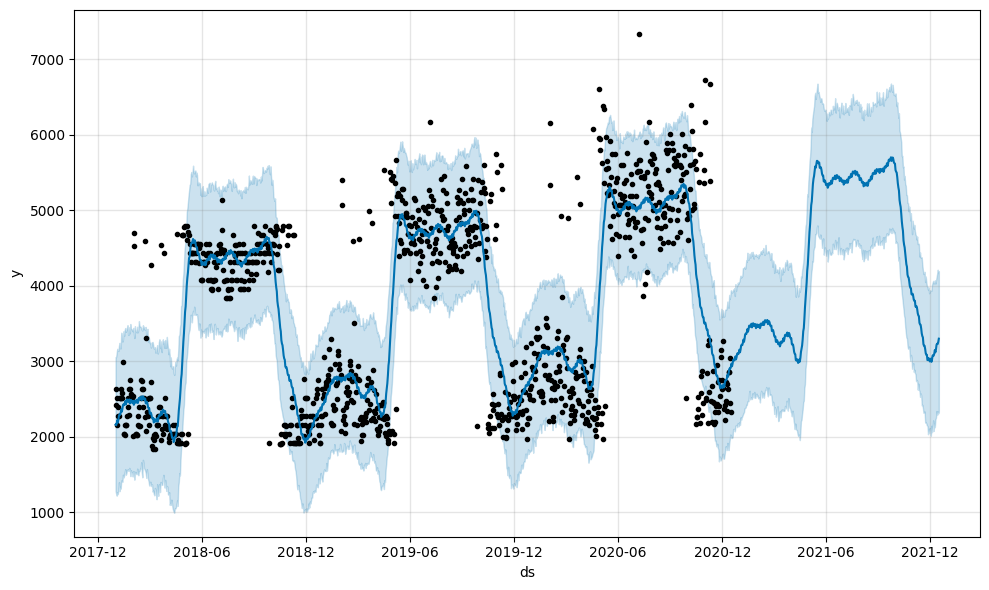

In [86]:
plotx = reloaded_model.plot(reforecast)

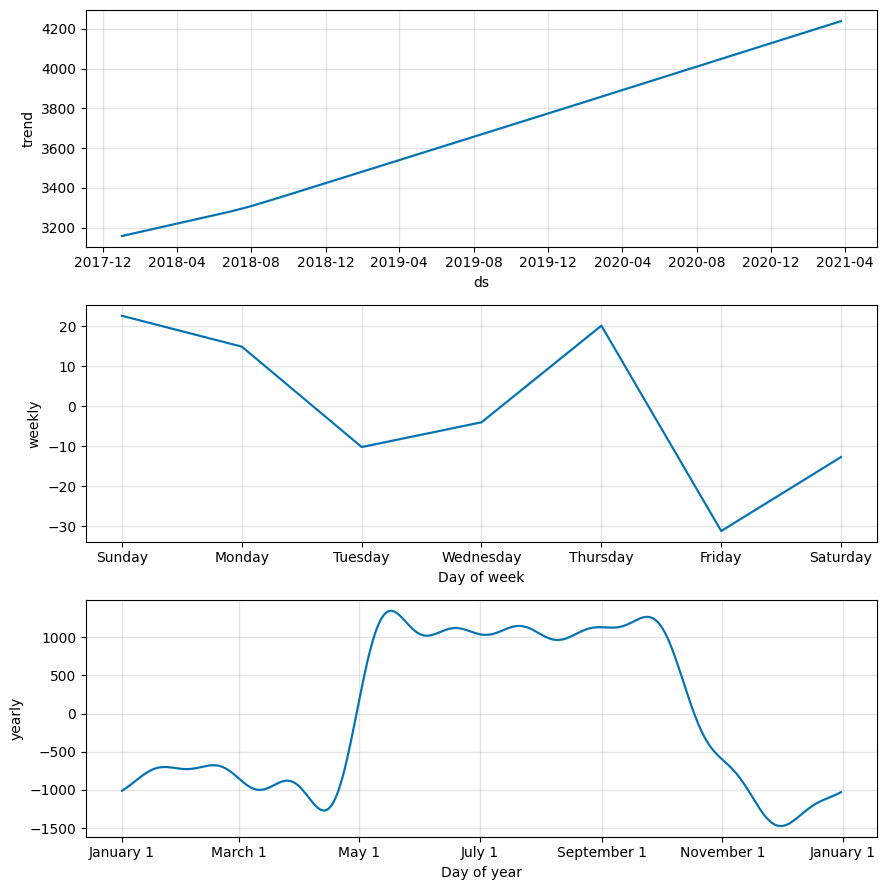

In [83]:
plot1 = reloaded_model.plot_components(reforecast)

## Loop Through All the Store and Vehicle Combinations

In [90]:
for store, product in itertools.product(df["Store"].unique(), df["Product"].unique()):
    print(build_model(df, product, store))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/nn9asbh4.json
DEBUG:cmdstanpy:input tempfile: /var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/su02k3od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/valentinmonney/Desktop/Full Stack Machine Learning/fullstack/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77744', 'data', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/nn9asbh4.json', 'init=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/su02k3od.json', 'output', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/prophet_model2rrbw6km/prophet_model-20231215145916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:59:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:

Model fit for product: TESLA_MODEL_X in store:LOS_ANGELES
Model fit for product: TESLA_MODEL_S in store:LOS_ANGELES


DEBUG:cmdstanpy:input tempfile: /var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/u5utia7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/valentinmonney/Desktop/Full Stack Machine Learning/fullstack/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72478', 'data', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/nlf_mmlx.json', 'init=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/u5utia7x.json', 'output', 'file=/var/folders/1v/qr8xwzq52nn435k6s4j2ln3c0000gn/T/tmpqrlg0av3/prophet_modell1nslyle/prophet_model-20231215145916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:59:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:59:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonal

Model fit for product: TESLA_MODEL_X in store:SAN_FRANCISCO
Model fit for product: TESLA_MODEL_S in store:SAN_FRANCISCO


In [91]:
with open("serialized_model_TESLA_MODEL_S_LOS_ANGELES.json", "r") as fin:
    reloaded_model = model_from_json(json.load(fin))

In [92]:
future = reloaded_model.make_future_dataframe(periods=120, freq="D")
forecast = reloaded_model.predict(future)

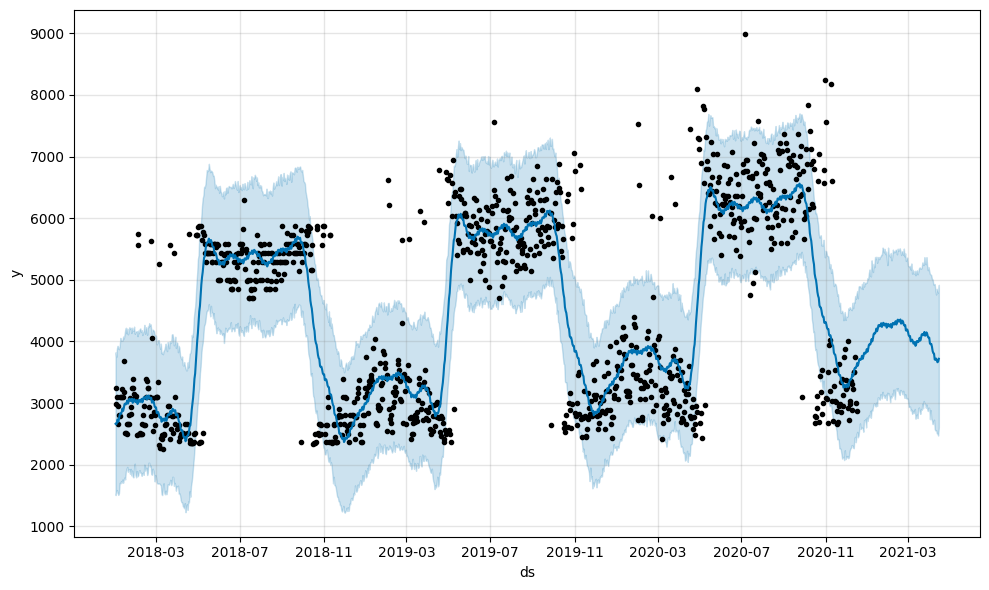

In [93]:
p = reloaded_model.plot(forecast)

# 8. Build Anvil App

In [98]:
os.listdir(".")

['serialized_model.json',
 'serialized_model_TESLA_MODEL_S_SAN_FRANCISCO.json',
 'Facebook Prophet.ipynb',
 'serialized_model_TESLA_MODEL_X_SAN_FRANCISCO.json',
 'TeslaSalesCompleted',
 'serialized_model_TESLA_MODEL_X_LOS_ANGELES.json',
 'serialized_model_TESLA_MODEL_S_LOS_ANGELES.json',
 '.ipynb_checkpoints',
 'dataset.csv']

## Create Notebook Uplink

In [99]:
# %pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached future-0.18.3-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=2ad1c7948685a8436c0e7cbbfa3f385936bdb8df51ce6d871cfd86fb7a37516d
  Stored in directory: /Users/valentinmonney/Library/Caches/pip/wheels/e8/9d/fd/0a594a1bc8d493935d319ac40d64d79f5b4117ef4d37b1b678
Successfully built ws4py
Note: you may need to restart the kernel to use updated packages.


In [101]:
anvil.server.connect("server_GWYAJOLPTVYGHSL2GOFRLULC-TJHOHPYVW3LBYBMY")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


## Build a Jupyter Callable Function

In [107]:
# Decorator for Anvil uplink
@anvil.server.callable
def forecast_future(model, timeframe):
    # Load the model form the disc
    with open(model, "r") as f:
        m = model_from_json(json.load(f))

    # Make a prediction
    future = m.make_future_dataframe(periods=int(timeframe), freq="D")
    forecast = m.predict(future)

    # Filtered the data we return back to the user
    forecast = forecast[["ds", "yhat_lower", "yhat", "yhat_upper"]]
    records = forecast.to_dict(orient="records")

    # Grab the columns to set names in the Data Grid
    columns = list(forecast.columns)

    return columns, records

In [104]:
columns, records = forecast_future(
    "serialized_model_TESLA_MODEL_S_SAN_FRANCISCO.json", 50
)

In [106]:
[{"id": col, "title": col, "data_key": col} for col in columns]

[{'id': 'ds', 'title': 'ds', 'data_key': 'ds'},
 {'id': 'yhat_lower', 'title': 'yhat_lower', 'data_key': 'yhat_lower'},
 {'id': 'yhat', 'title': 'yhat', 'data_key': 'yhat'},
 {'id': 'yhat_upper', 'title': 'yhat_upper', 'data_key': 'yhat_upper'}]

## Add Client Side Scripts